# Four-step Transportation Model

This is an update of a [blog post](https://davidabailey.com/articles/Creating-a-Four-step-Transportation-Model-in-Python) I wrote three years ago. I have since created classes to simplify the process of creating a four-step model. The two classes we will use are Zones and OriginDestinationDataFrame.

In [1]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import us

from dpd.modeling import Zones, OriginDestinationDataFrame

/usr/local/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
YEAR = "2017"

state = widgets.Select(options = list(map(lambda x: x.name, us.STATES)), description = "State", rows=10)
display(state)

Select(description='State', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Co…

The Zones class defines our analysis zones for the four step model. It is based on a Geopandas GeoDataFrame so it includes a geometry column that maps each zone. The other important columns are Production and Attraction which include the production and attraction data for each zone and the index which is used by the OriginDestinationDataFrame. Zones can be automatically created from US Census data with the from_uscensus method. Otherwise you need to create a GeoDataFrame with the aforementioned columns.

In [3]:
zones = Zones.from_uscensus(str(us.states.lookup(state.value).fips), YEAR)

In [4]:
zones.head(1)

,Name,Production,Attraction,state,county,tract,STATEFP,COUNTYFP,TRACTCE,NAME_y,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
GEOID,,,,,,,,,,,,,,,,,,
35047957500,"Census Tract 9575, San Miguel County, New Mexico",4117,None,35,047,957500,35,047,957500,9575,Census Tract 9575,G5020,S,9014844373,51188901,+35.5028648,-104.5780441,"POLYGON ((-105.54769 35.78157, -105.54724 35.7..."


One of nice things about this being a GeoDataFrame is that you can easily plot it. In this case we can plot the "Production density" which is really just the population density. We can see each zone (big in rural areas, small in urban areas) and we can see the urban areas have higher densities. This is step one of our four-step model.

<AxesSubplot:>

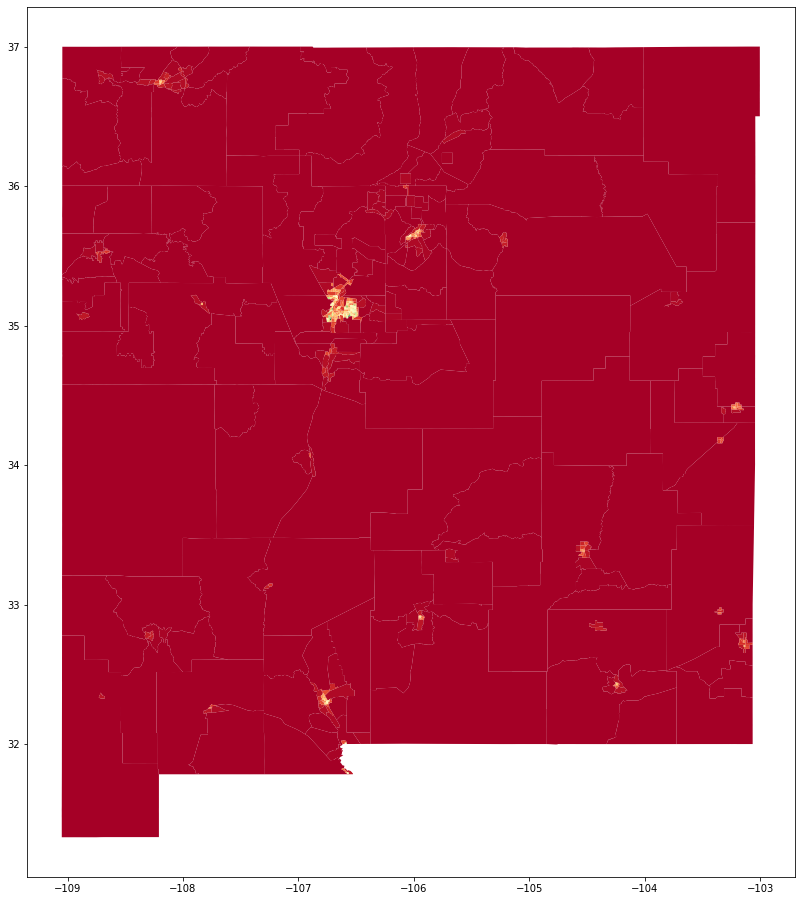

In [5]:
zones["Production density"] = zones["Production"].map(int) / zones["ALAND"]
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
zones.plot(column="Production density", cmap="RdYlGn", ax=ax)

Next we need to create a OriginDestinationDataFrame. We could compute this directly from our Zones object above, but we can also create this by downloading the US Census LODES data using the from_lodes method. This data is already organized as an origin-destination matrix. This is step two of the four-step model.

In [6]:
od = OriginDestinationDataFrame.from_lodes(us.states.lookup(state.value).abbr.lower(), YEAR)

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (28,29,31,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
od

w_geocode          h_geocode  S000  SA01  \
trct_w      trct_h                                                          
35001000107 35001000107   6300180019282126   6300180019290148    22     0   
            35001000108   1050030003214025   1050030003244008     3     1   
            35001000109    350010001071008    350010001091010     1     0   
            35001000111    350010001071008    350010001112007     1     1   
            35001000112   1750050005356019   1750050005607029     5     0   
...                                    ...                ...   ...   ...   
35061971400 35061970902   7012394280036520   7012394180421028    22    12   
            35061971000  17180365986092548  17180365790119446    62    15   
            35061971100   4207436568023410   4207436532013085    13     3   
            35061971300   3506197140017249   3506197130011257    11     3   
            35061971400  16128506844079144  16128506844079084    66    16   

                         SA02  SA03  SE01  SE02  SE03  SI01  SI02  SI03  \
trct_w      trct_h                                                        
35001000107 35001000107     9    13     7     8     7     2     0    20   
            35001000108     1     1     0     3     0     0     0     3   
            35001000109     1     0     1     0     0     0     0     1   
            35001000111     0     0     0     0     1     0     0     1   
            35001000112     0     5     3     0     2     1     0     4   
...                       ...   ...   ...   ...   ...   ...   ...   ...   
35061971400 35061970902     4     6     5    11     6     8     8     6   
            35061971000    38     9     4    40    18    13    38    11   
            35061971100     8     2     1     6     6     2     8     3   
            35061971300     7     1     2     6     3     1     2     8   
            35061971400    35    15    14    27    25    13    23    30   

                         createdate  
trct_w      trct_h                   
35001000107 35001000107   363434850  
            35001000108    60572475  
            35001000109    20190825  
            35001000111    20190825  
            35001000112   100954125  
...                             ...  
35061971400 35061970902   403816500  
            35061971000   989350425  
            35061971100   242289900  
            35061971300   201908250  
            35061971400   928777950  

[87659 rows x 13 columns]

Notice we use a multi-index instead of an index and column. This is because most zones do not have trips to other zones. We could unstack this dataframe to create a dataframe with the index as the origin and the columns as the destination. However, this creates many relationships (159,845 or 65% in this case) with no trips (NaN). 

In [8]:
od["S000"].unstack()

trct_h,35001000107,35001000108,35001000109,35001000110,35001000111,35001000112,35001000113,35001000114,35001000115,35001000116,...,35061970404,35061970405,35061970700,35061970800,35061970901,35061970902,35061971000,35061971100,35061971300,35061971400
trct_w,,,,,,,,,,,,,,,,,,,,,
35001000107,22.0,3.0,1.0,NaN,1.0,5.0,2.0,2.0,1.0,1.0,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35001000108,8.0,16.0,6.0,2.0,13.0,3.0,6.0,3.0,8.0,1.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0,2.0
35001000109,5.0,10.0,31.0,16.0,8.0,8.0,16.0,9.0,14.0,4.0,...,4.0,1.0,1.0,NaN,2.0,1.0,3.0,2.0,1.0,NaN
35001000110,7.0,8.0,5.0,20.0,15.0,8.0,7.0,4.0,10.0,3.0,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,4.0
35001000111,4.0,5.0,1.0,9.0,18.0,3.0,6.0,5.0,1.0,2.0,...,2.0,NaN,1.0,2.0,NaN,4.0,1.0,1.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35061970902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,3.0,4.0,4.0,5.0,5.0,2.0,3.0,2.0,1.0
35061971000,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,...,19.0,6.0,30.0,48.0,22.0,4.0,56.0,9.0,12.0,9.0
35061971100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,11.0,10.0,3.0,7.0,8.0,3.0,NaN


We are going to skip step three for now. That step will probably get its own notebook. In step four, we assign traffic to our transportation network. For this we need to create a network. We start by building a simple network based on our zones by reducing each zone to it's centroid. We then connect the neighboring centroids.

In [9]:
zones.build_graph()

/usr/local/lib/python3.8/site-packages/dpd/modeling/zones.py:62: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self["aea_centroid"] = self.centroid.map(epsg4326_to_aea)
/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:167: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


We can then assign our OriginDestinationDataFrame traffic to our Zones transportation network.

In [10]:
od.route_assignment(zones)

And we can plot the final result. This looks about right at first glance. Please take a look at the underlying methods to see what is going on.

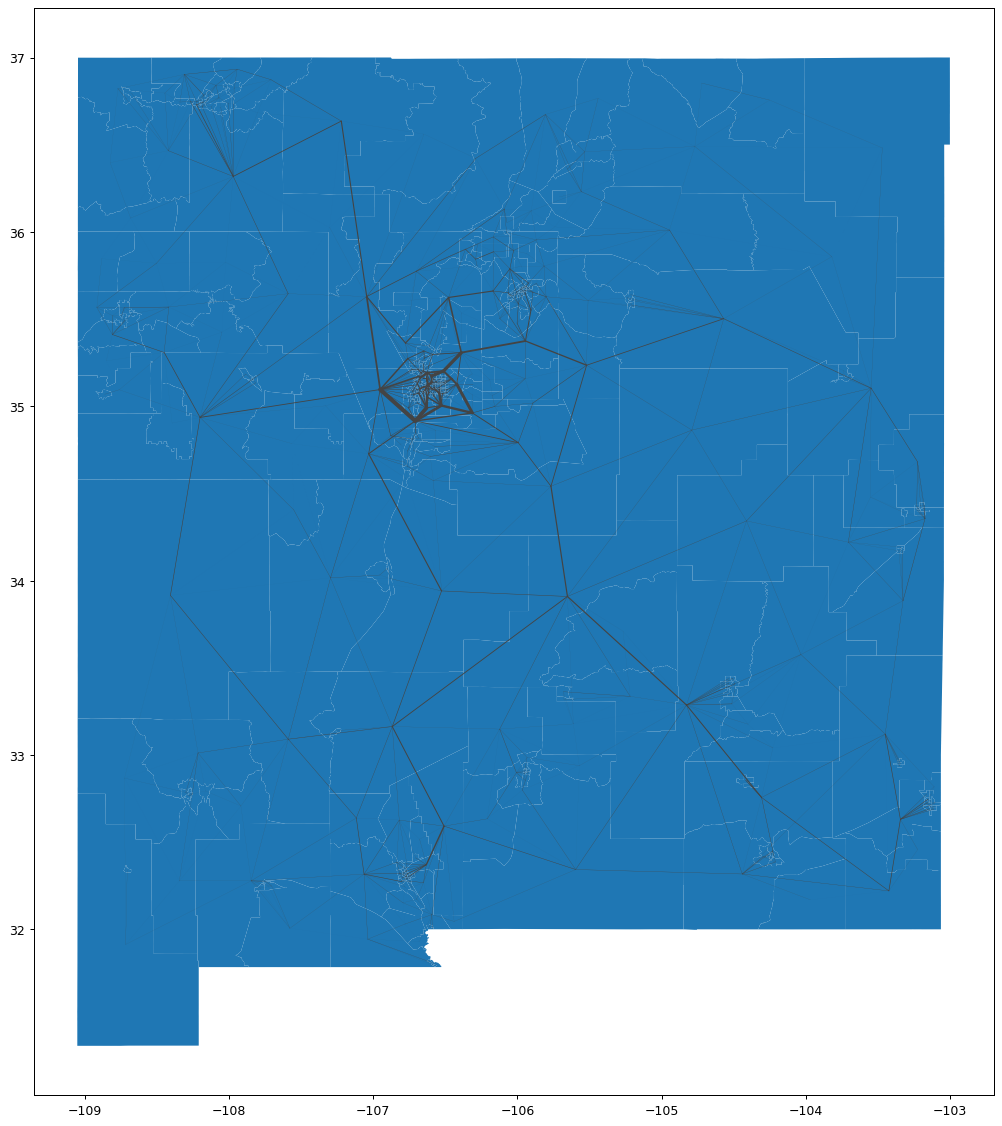

In [11]:
fig = plt.figure(1, figsize=(18, 16), dpi=90)
ax = fig.add_subplot(111)
zones.visualize_route_assignment(ax=ax)

In [12]:
zones.head()

,Name,Production,Attraction,state,county,tract,STATEFP,COUNTYFP,TRACTCE,NAME_y,...,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Production density,centroid,aea_centroid
GEOID,,,,,,,,,,,,,,,,,,,,,
35047957500,"Census Tract 9575, San Miguel County, New Mexico",4117,None,35,047,957500,35,047,957500,9575,...,G5020,S,9014844373,51188901,+35.5028648,-104.5780441,"POLYGON ((-105.54769 35.78157, -105.54724 35.7...",4.566912e-07,POINT (35.502 -104.570),POINT (-735653.985 -495590.428)
35047957200,"Census Tract 9572, San Miguel County, New Mexico",4092,None,35,047,957200,35,047,957200,9572,...,G5020,S,15733174,6424,+35.6473732,-105.2211779,"POLYGON ((-105.23194 35.65885, -105.23188 35.6...",2.600874e-04,POINT (35.640 -105.214),POINT (-789237.725 -474350.878)
35047957400,"Census Tract 9574, San Miguel County, New Mexico",4521,None,35,047,957400,35,047,957400,9574,...,G5020,S,14600166,0,+35.5807024,-105.2113296,"POLYGON ((-105.23855 35.58998, -105.23831 35.5...",3.096540e-04,POINT (35.581 -105.211),POINT (-789651.239 -481263.576)
35047957300,"Census Tract 9573, San Miguel County, New Mexico",2809,None,35,047,957300,35,047,957300,9573,...,G5020,S,7583010,0,+35.6072892,-105.2054852,"POLYGON ((-105.23379 35.59926, -105.23336 35.5...",3.704334e-04,POINT (35.607 -105.205),POINT (-788849.833 -478212.862)
35047957700,"Census Tract 9577, San Miguel County, New Mexico",2110,None,35,047,957700,35,047,957700,9577,...,G5020,S,1619869122,16868,+35.2367157,-105.5262824,"POLYGON ((-105.71814 35.48276, -105.71813 35.4...",1.302574e-06,POINT (35.235 -105.520),POINT (-820079.792 -518884.359)


In [ ]:
import folium


points = folium.features.GeoJson(output)

m = folium.Map(zoom_start=9)
m.add_children(points)